In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.window import Window
spark = SparkSession.builder.getOrCreate()
#from functools import reduce
#import pandas

In [18]:
## Data was collected by county and combined all collisions file to a single dataframe
##all parties file to a single dataframe and all victims file to a single dataframe

df_coll=spark.read.format("csv").option("header", "true").load("gs://collision_data_bucket/Collisions_data_lat/*-c.csv")
df_part=spark.read.format("csv").option("header", "true").load("gs://collision_data_bucket/Collisions_data_lat/*-p.csv")
df_vict=spark.read.format("csv").option("header", "true").load("gs://collision_data_bucket/Collisions_data_lat/*-v.csv")

In [108]:
df_coll.count()

963730

In [17]:
df_coll.printSchema()
df_part.printSchema()
df_vict.printSchema()

root
 |-- CASE_ID: string (nullable = true)
 |-- ACCIDENT_YEAR: string (nullable = true)
 |-- PROC_DATE: string (nullable = true)
 |-- JURIS: string (nullable = true)
 |-- COLLISION_DATE: string (nullable = true)
 |-- COLLISION_TIME: string (nullable = true)
 |-- OFFICER_ID: string (nullable = true)
 |-- REPORTING_DISTRICT: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- CHP_SHIFT: string (nullable = true)
 |-- POPULATION: string (nullable = true)
 |-- CNTY_CITY_LOC: string (nullable = true)
 |-- SPECIAL_COND: string (nullable = true)
 |-- BEAT_TYPE: string (nullable = true)
 |-- CHP_BEAT_TYPE: string (nullable = true)
 |-- CITY_DIVISION_LAPD: string (nullable = true)
 |-- CHP_BEAT_CLASS: string (nullable = true)
 |-- BEAT_NUMBER: string (nullable = true)
 |-- primary_rd: string (nullable = true)
 |-- SECONDARY_RD: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- DIRECTION: string (nullable = true)
 |-- INTERSECTION: string (nullable = true

In [4]:
##DATA CLEANING


df_coll=df_coll.withColumn('primary_rd',when(df_coll['primary_rd'].like('RT 5 %'),'RT 5').when(df_coll['primary_rd'].like('INTERSTATE 5 %'),'RT 5').when(df_coll['primary_rd'].like('I-5 %'),'RT 5').when(df_coll['primary_rd'].like('I-10 %'),'RT 10').when(df_coll['primary_rd'].like('RT 10 %'),'RT 10').when(df_coll['primary_rd'].like('INTERSTATE 10 %'),'RT 10').when(df_coll['primary_rd'].like('INTERSTATE 880 %'),'RT 880').when(df_coll['primary_rd'].like('RT 880 %'),'RT 880').when(df_coll['primary_rd'].like('%I-880 %'),'RT 880').when(df_coll['primary_rd'].like('"I-880 %'),'RT 880').when(df_coll['primary_rd'].like('INTERSTATE 880%'),'RT 880').when(df_coll['primary_rd'].like('I 880 %'),'RT 880').when(df_coll['primary_rd'].like('I880 %'),'RT 880').when(df_coll['primary_rd'].like('STATE ROUTE 99 %'),'RT 99').when(df_coll['primary_rd'].like('RT 99 %'),'RT 99').when(df_coll['primary_rd'].like('SR-99 %'),'RT 99').when(df_coll['primary_rd'].like('STATE ROUTE 99'),'RT 99').when(df_coll['primary_rd'].like('STATE ROUTE-99 %'),'RT 99').when(df_coll['primary_rd'].like('SR 99 %'),'RT 99').when(df_coll['primary_rd'].like('SR 99%'),'RT 99').otherwise(df_coll['primary_rd']))

df_coll=df_coll.withColumn('primary_rd',when(df_coll['primary_rd'].like('I-80 %'),'RT 80').when(df_coll['primary_rd'].like('RT 80 %'),'RT 80').when(df_coll['primary_rd'].like('INTERSTATE 80 %'),'RT 80').when(df_coll['primary_rd'].like('US-101 %'),'RT 101').otherwise(df_coll['primary_rd']))


df_coll=df_coll.withColumn('primary_rd',when(df_coll['primary_rd'].like('US 101 %'),'RT 101').when(df_coll['primary_rd'].like('U.S. 101 %'),'RT 101').when(df_coll['primary_rd'].like('U.S.-101 %'),'RT 101').otherwise(df_coll['primary_rd']))
df_coll=df_coll.withColumn('primary_rd',when(df_coll['primary_rd'].like('US101 %'),'RT 101').otherwise(df_coll['primary_rd']))
df_coll=df_coll.withColumn('pcf_viol_category',when(df_coll['pcf_viol_category']=='01','dui').when(df_coll['pcf_viol_category']=='02','Impeding_traffic').when(df_coll['pcf_viol_category']=='03','Speeding').when(df_coll['pcf_viol_category']=='04','Following_closely').when(df_coll['pcf_viol_category']=='05','Wrong_side_of_road').when(df_coll['pcf_viol_category']=='06','Improper_passing').when(df_coll['pcf_viol_category']=='07','Unsafe_lane_change').when(df_coll['pcf_viol_category']=='08','Improper_turning').when(df_coll['pcf_viol_category']=='09','Auto_right_of_way').when(df_coll['pcf_viol_category']=='10','Ped_right_of_way').when(df_coll['pcf_viol_category']=='11','Ped_violation').when(df_coll['pcf_viol_category']=='12','Traffic_signals').when(df_coll['pcf_viol_category']=='13','Parking_hazard').when(df_coll['pcf_viol_category']=='14','Lights').when(df_coll['pcf_viol_category']=='15','Brakes'))

In [7]:
#df_coll.where(col('primary_rd').like('US101%')).select('primary_rd').distinct().show()
df_coll.groupby('accident_year').agg(count('case_id').alias('collision_total')).show()
temp=df_part.select('accident_year','case_id').distinct()
#temp.show()
temp.groupby('accident_year').agg(count('case_id').alias('parties_total')).show()
temp=df_vict.select('accident_year','case_id').distinct()
temp.groupby('accident_year').agg(count('case_id').alias('victim_total')).show()

+-------------+---------------+
|accident_year|collision_total|
+-------------+---------------+
|         2016|         198899|
|         2019|         190399|
|         2017|         197146|
|         2018|         195449|
|         2015|         181837|
+-------------+---------------+

+-------------+-------------+
|accident_year|parties_total|
+-------------+-------------+
|         2016|       198899|
|         2019|       190399|
|         2017|       197146|
|         2018|       195449|
|         2015|       181837|
+-------------+-------------+

+-------------+------------+
|accident_year|victim_total|
+-------------+------------+
|         2016|      198899|
|         2019|      190399|
|         2017|      197146|
|         2018|      195449|
|         2015|      181837|
+-------------+------------+



+-------------+------+
|accident_year|total1|
+-------------+------+
|         2015|181837|
|         2016|198899|
|         2017|197146|
|         2018|195449|
|         2019|190399|
+-------------+------+



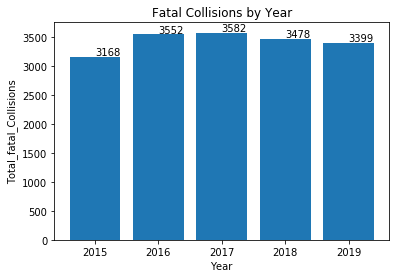

In [25]:
##1 Collision Severity
#A- Incapacitating injury-3 rows

#https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EMM_EPM0_PTE_SCA_DPG&f=M

import matplotlib.pyplot as plt

c=df_coll.groupby('accident_year').agg(count('case_id').alias('total1'))
c.orderBy(col('accident_year').asc()).show()
temp=df_coll
temp=temp.withColumn('Collision_S',when((temp['COLLISION_SEVERITY']==1),'fatal').when(((temp['COLLISION_SEVERITY']==2)|(temp['COLLISION_SEVERITY']==3)|(temp['COLLISION_SEVERITY']==4)),'injured').otherwise('property_damange_only'))
temp=temp.groupby('accident_year','Collision_S').agg(count('chp_shift').alias("Coll_severity_count"))
temp=temp.join(c,'accident_year',"inner")
temp=temp.withColumn('Perc_coll_by_severity %',f.round(expr('Coll_severity_count*100/total1'),1))
temp=temp.filter(temp['Collision_S']=='fatal').orderBy(col('accident_year').asc())
xaxis=['2015','2016','2017','2018','2019']
yaxis=list(temp.select('Coll_severity_count').toPandas()['Coll_severity_count'])
#print(yaxis)

plt.bar(xaxis, yaxis, width=0.8, bottom=None, align='center')
plt.xlabel('Year')
plt.ylabel('Total_fatal_Collisions')
plt.title('Fatal Collisions by Year')

for index, value in enumerate(yaxis):
    plt.text(index, value+30, str(value))



#fig, ax = plt.subplots()
#ax.bar(yaxis, performance, xerr=error, align='center')
#ax.set_yticks(y_pos)
#ax.set_yticklabels(people)
#ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xlabel('Performance')
#ax.set_title('How fast do you want to go today?')


In [20]:
##2 Top 5 busiest routes per year
#https://dot.ca.gov/programs/traffic-operations/census/traffic-volumes/2017/route-5-6
    
temp=df_coll.filter((df_coll['primary_rd'].isNotNull())).groupby('ACCIDENT_YEAR','primary_rd').agg(count('chp_shift').alias("collision_counts_location")).sort('collision_counts_location',ascending=False)
window_spec=Window.partitionBy('ACCIDENT_YEAR').orderBy(col('collision_counts_location').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp.filter(temp['r']<6).orderBy(col('ACCIDENT_YEAR').desc(),col('collision_counts_location').desc()).show()



+-------------+----------+-------------------------+---+
|ACCIDENT_YEAR|primary_rd|collision_counts_location|  r|
+-------------+----------+-------------------------+---+
|         2019|      RT 5|                     5371|  1|
|         2019|    RT 101|                     5230|  2|
|         2019|     RT 10|                     3308|  3|
|         2019|     RT 99|                     2323|  4|
|         2019|     RT 80|                     2186|  5|
|         2018|      RT 5|                     5423|  1|
|         2018|    RT 101|                     5229|  2|
|         2018|     RT 10|                     3264|  3|
|         2018|     RT 99|                     2395|  4|
|         2018|     RT 80|                     2328|  5|
|         2017|      RT 5|                     5798|  1|
|         2017|    RT 101|                     5537|  2|
|         2017|     RT 10|                     3407|  3|
|         2017|     RT 99|                     2353|  4|
|         2017|     RT 80|     

In [6]:

r_list=['RT 5','RT 101', 'RT 10', 'RT 80','RT 99']
temp=df_coll.filter(col('primary_rd').isin(r_list))
temp=temp.filter((temp['primary_rd'].isNotNull())&(temp['city']!='UNINCORPORATED')).groupby('ACCIDENT_YEAR','primary_rd','city').agg(count('chp_shift').alias("collision_counts_location")).sort('collision_counts_location',ascending=False)
window_spec=Window.partitionBy('ACCIDENT_YEAR','primary_rd').orderBy(col('collision_counts_location').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp.filter(temp['r']<4).orderBy(col('ACCIDENT_YEAR').desc(),col('city').desc(),col('collision_counts_location').desc()).show()

+-------------+----------+-------------+-------------------------+---+
|ACCIDENT_YEAR|primary_rd|         city|collision_counts_location|  r|
+-------------+----------+-------------+-------------------------+---+
|         2019|     RT 80|      VALLEJO|                      139|  3|
|         2019|    RT 101|     SAN JOSE|                      334|  2|
|         2019|    RT 101|SAN FRANCISCO|                      246|  3|
|         2019|     RT 80|SAN FRANCISCO|                      221|  1|
|         2019|      RT 5|    SAN DIEGO|                      471|  2|
|         2019|     RT 99|   SACRAMENTO|                      267|  1|
|         2019|      RT 5|   SACRAMENTO|                      254|  3|
|         2019|     RT 10|       POMONA|                      209|  3|
|         2019|     RT 10|      ONTARIO|                      249|  2|
|         2019|    RT 101|  LOS ANGELES|                     1145|  1|
|         2019|      RT 5|  LOS ANGELES|                      880|  1|
|     

In [112]:
##3 Collision in each route by violation category

r_list=['RT 5','RT 101', 'RT 10', 'RT 80','RT 99']
temp=df_coll.filter(col('primary_rd').isin(r_list))
temp=temp.withColumn('pcf_viol_category',when(temp['pcf_viol_category']=='01','dui').when(temp['pcf_viol_category']=='02','Impeding_traffic').when(temp['pcf_viol_category']=='03','Speeding').when(temp['pcf_viol_category']=='04','Following_closely').when(temp['pcf_viol_category']=='05','Wrong_side_of_road').when(temp['pcf_viol_category']=='06','Improper_passing').when(temp['pcf_viol_category']=='07','Unsafe_lane_change').when(temp['pcf_viol_category']=='08','Improper_turning').when(temp['pcf_viol_category']=='09','Auto_right_of_way').when(temp['pcf_viol_category']=='10','Ped_right_of_way').when(temp['pcf_viol_category']=='11','Ped_violation').when(temp['pcf_viol_category']=='12','Traffic_signals').when(temp['pcf_viol_category']=='13','Parking_hazard').when(temp['pcf_viol_category']=='14','Lights').when(temp['pcf_viol_category']=='15','Brakes'))
temp=temp.filter((temp['primary_rd'].isNotNull())).groupby('ACCIDENT_YEAR','primary_rd','pcf_viol_category').agg(count('chp_shift').alias("collision_counts_loc&categ")).sort('collision_counts_loc&categ',ascending=False)
window_spec=Window.partitionBy('primary_rd','ACCIDENT_YEAR').orderBy(col('collision_counts_loc&categ').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp.filter(temp['r']<4).orderBy(col('primary_rd').asc(),col('pcf_viol_category').desc(),col('ACCIDENT_YEAR').desc()).show(40,truncate=False)
#temp.filter(temp['r']<4).orderBy('accident_year').show(40,truncate=False)

+-------------+----------+------------------+--------------------------+---+
|ACCIDENT_YEAR|primary_rd|pcf_viol_category |collision_counts_loc&categ|r  |
+-------------+----------+------------------+--------------------------+---+
|2019         |RT 10     |Unsafe_lane_change|379                       |3  |
|2018         |RT 10     |Unsafe_lane_change|379                       |3  |
|2017         |RT 10     |Unsafe_lane_change|384                       |3  |
|2016         |RT 10     |Unsafe_lane_change|366                       |3  |
|2015         |RT 10     |Unsafe_lane_change|318                       |3  |
|2019         |RT 10     |Speeding          |1965                      |1  |
|2018         |RT 10     |Speeding          |1974                      |1  |
|2017         |RT 10     |Speeding          |2049                      |1  |
|2016         |RT 10     |Speeding          |2027                      |1  |
|2015         |RT 10     |Speeding          |1435                      |1  |

In [8]:
##3 Collision_violation by percentage


#temp=df_coll.join(df_id,"case_id","inner")
c=df_coll.groupby('accident_year').agg(count('case_id').alias('total1'))
c.orderBy(col('accident_year').asc()).show()

temp=df_coll
temp=temp.withColumn('pcf_viol_category',when(temp['pcf_viol_category']=='01','dui').when(temp['pcf_viol_category']=='02','Impeding_traffic').when(temp['pcf_viol_category']=='03','Speeding').when(temp['pcf_viol_category']=='04','Following_closely').when(temp['pcf_viol_category']=='05','Wrong_side_of_road').when(temp['pcf_viol_category']=='06','Improper_passing').when(temp['pcf_viol_category']=='07','Unsafe_lane_change').when(temp['pcf_viol_category']=='08','Improper_turning').when(temp['pcf_viol_category']=='09','Auto_right_of_way').when(temp['pcf_viol_category']=='10','Ped_right_of_way').when(temp['pcf_viol_category']=='11','Ped_violation').when(temp['pcf_viol_category']=='12','Traffic_signals').when(temp['pcf_viol_category']=='13','Parking_hazard').when(temp['pcf_viol_category']=='14','Lights').when(temp['pcf_viol_category']=='15','Brakes'))
temp=temp.filter((df_coll['pcf_viol_category'].isNotNull())&(df_coll['pcf_viol_category']!='null')).groupby('accident_year','pcf_viol_category').agg(count('chp_shift').alias("total")).sort('total',ascending=False)
window_spec=Window.partitionBy('accident_year').orderBy(col('total').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp=temp.filter(temp['r']<6).orderBy(col('accident_year').desc(),col('total').desc())

temp=temp.join(c,'accident_year',"inner")
temp=temp.withColumn('Perc_coll_by_violation',f.round(expr('total*100/total1'),1))
#temp.show()
#temp=temp.orderby(col('db_year').desc(),col('r').asc())
temp.filter((temp['pcf_viol_category']!='null')).select('accident_year','pcf_viol_category','Perc_coll_by_violation','r').orderBy(col('accident_year').desc(),col('r').asc()).show(40,truncate=False)



+-------------+------+
|accident_year|total1|
+-------------+------+
|         2015|181837|
|         2016|198899|
|         2017|197146|
|         2018|195449|
|         2019|190399|
+-------------+------+

+-------------+-----------------+----------------------+---+
|accident_year|pcf_viol_category|Perc_coll_by_violation|r  |
+-------------+-----------------+----------------------+---+
|2019         |Speeding         |31.4                  |1  |
|2019         |Auto_right_of_way|15.8                  |2  |
|2019         |Improper_turning |14.6                  |3  |
|2019         |Traffic_signals  |8.7                   |4  |
|2019         |dui              |7.5                   |5  |
|2018         |Speeding         |31.3                  |1  |
|2018         |Auto_right_of_way|16.0                  |2  |
|2018         |Improper_turning |14.8                  |3  |
|2018         |Traffic_signals  |8.6                   |4  |
|2018         |dui              |7.5                   |5  |

In [60]:
##5 Party sobriety

#B - Had Been Drinking, Under Influence
#C - Had Been Drinking, Not Under Influence
#temp=df_coll
#temp=temp.join(df_part,'case_id',"inner")
#temp=df_part.select('ACCIDENT_YEAR','party_sobriety','CHP_VEH_TYPE_TOWED').distinct()
#temp=temp.filter((temp['party_sobriety']=='B')|(temp['party_sobriety']=='C')|(temp['party_sobriety']=='D')|((temp['party_sobriety']=='G'))).groupby('ACCIDENT_YEAR','party_sobriety').agg(count('CHP_VEH_TYPE_TOWED').alias('coll_involv_alcohol')).orderBy(col('ACCIDENT_YEAR').desc())
#temp.groupby('accident_year').agg(sum('coll_involv_alcohol').alias('Alcohol_involved_coll')).orderBy('accident_year').show()
#temp.printSchema()
df_coll.filter(df_coll['ALCOHOL_INVOLVED']=='Y').groupby('accident_year').count().orderBy('accident_year').show()

+-------------+-----+
|accident_year|count|
+-------------+-----+
|         2015|18627|
|         2016|20105|
|         2017|19736|
|         2018|20012|
|         2019|19748|
+-------------+-----+



In [74]:
##6 Age group involved in collison

#temp=df_coll.join(df_id,'case_id',"inner")
#temp=temp.join(df_part,"case_id","inner")
temp=df_part.join(df_coll,["case_id", "accident_year"],"inner")
temp=temp.withColumn('party_age',temp['party_age'].cast(IntegerType()))
temp=temp.withColumn('Age_group',when(((col("party_age")>=15)&(col("party_age")<20)),'Between_15_and_20').when(((col("party_age")>=20)&(col("party_age")<30)),'Between_20_and_30').when(((col("party_age")>=30)&(col("party_age")<40)),'Between_30_and_40').when(((col("party_age")>=40)&(col("party_age")<50)),'Between_40_and_50').when(((col("party_age")>=50)&(col("party_age")<60)),'Between_50_and_60').when(((col("party_age")>=60)&(col("party_age")<100)),'Greater_than_60').otherwise(0))
temp.filter(temp['Age_group']!='0').groupby('accident_year','Age_group').agg(count('CHP_VEH_TYPE_TOWED').alias('Collision_by_age_group')).orderBy(col('Age_group').asc(),col('accident_year').desc()).show(30)

temp.filter((temp['Age_group']!='0')&(temp['ALCOHOL_INVOLVED']=='Y')).groupby('accident_year','Age_group').agg(count('CHP_VEH_TYPE_TOWED').alias('Collision_by_age_group')).orderBy(col('Age_group').asc(),col('accident_year').desc()).show(30)



+-------------+-----------------+----------------------+
|accident_year|        Age_group|Collision_by_age_group|
+-------------+-----------------+----------------------+
|         2019|Between_15_and_20|                    54|
|         2018|Between_15_and_20|                    31|
|         2017|Between_15_and_20|                    48|
|         2016|Between_15_and_20|                    42|
|         2015|Between_15_and_20|                    22|
|         2019|Between_20_and_30|                   788|
|         2018|Between_20_and_30|                   722|
|         2017|Between_20_and_30|                   718|
|         2016|Between_20_and_30|                   631|
|         2015|Between_20_and_30|                   552|
|         2019|Between_30_and_40|                  1147|
|         2018|Between_30_and_40|                  1115|
|         2017|Between_30_and_40|                  1118|
|         2016|Between_30_and_40|                  1062|
|         2015|Between_30_and_4

In [13]:
## By age group reason for collision

temp=df_part.join(df_coll,["case_id", "accident_year"],"inner")
temp=temp.withColumn('party_age',temp['party_age'].cast(IntegerType()))
temp=temp.withColumn('Age_group',when(((col("party_age")>=15)&(col("party_age")<20)),'Between_15_and_20').when(((col("party_age")>=20)&(col("party_age")<30)),'Between_20_and_30').when(((col("party_age")>=30)&(col("party_age")<40)),'Between_30_and_40').when(((col("party_age")>=40)&(col("party_age")<50)),'Between_40_and_50').when(((col("party_age")>=50)&(col("party_age")<60)),'Between_50_and_60').when(((col("party_age")>=60)&(col("party_age")<100)),'Greater_than_60').otherwise(0))
temp.filter((temp['Age_group']!='0')&((temp['pcf_viol_category']!='null'))&(temp['Age_group']=='Between_15_and_20')).groupby('accident_year','Age_group','pcf_viol_category').agg(count('CHP_VEH_TYPE_TOWED').alias('Coll_reason_by_age_group')).orderBy(col('accident_year').desc(),col('Coll_reason_by_age_group').desc()).show(3)

temp.filter((temp['Age_group']!='0')&(temp['pcf_viol_category']!='null')&(temp['Age_group']=='Between_20_and_30')).groupby('accident_year','Age_group','pcf_viol_category').agg(count('CHP_VEH_TYPE_TOWED').alias('Coll_reason_by_age_group')).orderBy(col('accident_year').desc(),col('Coll_reason_by_age_group').desc()).show(3)

temp.filter((temp['Age_group']!='0')&(temp['pcf_viol_category']!='null')&(temp['Age_group']=='Between_30_and_40')).groupby('accident_year','Age_group','pcf_viol_category').agg(count('CHP_VEH_TYPE_TOWED').alias('Coll_reason_by_age_group')).orderBy(col('accident_year').desc(),col('Coll_reason_by_age_group').desc()).show(3)

temp.filter((temp['Age_group']!='0')&(temp['pcf_viol_category']!='null')&(temp['Age_group']=='Between_40_and_50')).groupby('accident_year','Age_group','pcf_viol_category').agg(count('CHP_VEH_TYPE_TOWED').alias('Coll_reason_by_age_group')).orderBy(col('accident_year').desc(),col('Coll_reason_by_age_group').desc()).show(3)

temp.filter((temp['Age_group']!='0')&(temp['pcf_viol_category']!='null')&(temp['Age_group']=='Between_50_and_60')).groupby('accident_year','Age_group','pcf_viol_category').agg(count('CHP_VEH_TYPE_TOWED').alias('Coll_reason_by_age_group')).orderBy(col('accident_year').desc(),col('Coll_reason_by_age_group').desc()).show(3)

#temp.filter((temp['Age_group']!='0')&(temp['ALCOHOL_INVOLVED']=='Y')).groupby('accident_year','Age_group').agg(count('CHP_VEH_TYPE_TOWED').alias('Collision_by_age_group')).orderBy(col('Age_group').asc(),col('accident_year').desc()).show(30)

temp.filter((temp['Age_group']!='0')&(temp['Age_group']=='Greater_than_60')&(temp['pcf_viol_category']!='null')).groupby('accident_year','Age_group','pcf_viol_category').agg(count('CHP_VEH_TYPE_TOWED').alias('Coll_reason_by_age_group')).orderBy(col('accident_year').desc(),col('Coll_reason_by_age_group').desc()).show(3)


+-------------+-----------------+------------------+------------------------+
|accident_year|        Age_group| pcf_viol_category|Coll_reason_by_age_group|
+-------------+-----------------+------------------+------------------------+
|         2019|Between_15_and_20|          Speeding|                      20|
|         2019|Between_15_and_20| Auto_right_of_way|                      12|
|         2019|Between_15_and_20|  Improper_turning|                       6|
|         2019|Between_15_and_20|               dui|                       5|
|         2019|Between_15_and_20|   Traffic_signals|                       2|
|         2019|Between_15_and_20|Wrong_side_of_road|                       2|
|         2019|Between_15_and_20|  Improper_passing|                       1|
|         2019|Between_15_and_20|     Ped_violation|                       1|
|         2019|Between_15_and_20|Unsafe_lane_change|                       1|
|         2019|Between_15_and_20|            Brakes|            

+-------------+---------------+------------------+------------------------+
|accident_year|      Age_group| pcf_viol_category|Coll_reason_by_age_group|
+-------------+---------------+------------------+------------------------+
|         2019|Greater_than_60|          Speeding|                     319|
|         2019|Greater_than_60|  Improper_turning|                     132|
|         2019|Greater_than_60|Unsafe_lane_change|                     104|
|         2019|Greater_than_60| Auto_right_of_way|                      67|
|         2019|Greater_than_60|               dui|                      51|
|         2019|Greater_than_60|   Traffic_signals|                      36|
|         2019|Greater_than_60|Wrong_side_of_road|                      29|
|         2019|Greater_than_60|  Improper_passing|                      15|
|         2019|Greater_than_60|     Ped_violation|                       6|
|         2019|Greater_than_60|  Ped_right_of_way|                       2|
|         20

In [70]:
##7 Collision by road by type of vehicle



#temp=df_coll.join(df_id,'case_id',"inner")
#temp=temp.join(df_part,'case_id',"inner")
df_coll=df_coll.withColumn('Vehicle_type',when(df_coll['STWD_VEHTYPE_AT_FAULT']=='A','Passenger_Car').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='B','Passenger_Car').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='C','Motorcycle/Scooter').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='D','Pickup_or_Panel_Truck').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='E','Pickup_or_Panel_Truck').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='F','Truck/Truck_Tractor').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='G','Truck/Truck_Tractor').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='H','Schoolbus').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='I','Otherbus').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='J','Emergency_Vehicle').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='K','Construction_Equipment').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='L','Bicycle').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='M','Other Vehicle').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='N','Pedestrian').when(df_coll['STWD_VEHTYPE_AT_FAULT']=='O','Moped').otherwise('Null'))
temp=df_coll.filter(col('primary_rd').isin(r_list))

temp=temp.filter((temp['primary_rd'].isNotNull())&(temp['Vehicle_type']!='Null')).groupby('accident_year','primary_rd','Vehicle_type').agg(count('chp_shift').alias("coll_veh_type")).sort('coll_veh_type',ascending=False)
window_spec=Window.partitionBy('primary_rd','accident_year').orderBy(col('coll_veh_type').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp.filter(temp['r']<4).orderBy(col('primary_rd').asc(),col('Vehicle_type').asc(),col('accident_year').desc()).limit(40).toPandas()

,accident_year,primary_rd,Vehicle_type,coll_veh_type,r
0,2019,RT 10,Motorcycle/Scooter,141,3
1,2018,RT 10,Motorcycle/Scooter,150,3
2,2017,RT 10,Motorcycle/Scooter,198,3
3,2016,RT 10,Motorcycle/Scooter,174,3
4,2015,RT 10,Motorcycle/Scooter,140,3
5,2019,RT 10,Passenger_Car,2475,1
6,2018,RT 10,Passenger_Car,2414,1
7,2017,RT 10,Passenger_Car,2492,1
8,2016,RT 10,Passenger_Car,2496,1
9,2015,RT 10,Passenger_Car,1880,1


In [81]:
##8 % collision by vehicle category

temp=df_coll
df_ped=temp.filter((temp['pedestrian_accident'].isNotNull())&(temp['pedestrian_accident']=='Y')).groupby('accident_year').agg(count('chp_shift').alias('ped_count'))
df_ped=df_ped.join(c,"accident_year","inner")
#df_ped.select(expr('ped_count*100/total1').alias('Perc_ped_coll').show()
df_ped=df_ped.withColumn('Perc_ped_coll',f.round(expr('ped_count*100/total1'),1))
df_ped.select('accident_year','Perc_ped_coll').orderBy(col('accident_year').desc()).show()
              
df_cycle=temp.filter((temp['bicycle_accident'].isNotNull())&(temp['bicycle_accident']=='Y')).groupby('accident_year').agg(count('chp_shift').alias('cycle_count'))
df_cycle=df_cycle.join(c,'accident_year',"inner")
df_cycle=df_cycle.withColumn('Perc_cycle_coll',f.round(expr('cycle_count*100/total1'),1))
df_cycle.select('accident_year','Perc_cycle_coll').orderBy(col('accident_year').desc()).show()
                
df_motor=temp.filter((temp['motorcycle_accident'].isNotNull())&(temp['motorcycle_accident']=='Y')).groupby('accident_year').agg(count('chp_shift').alias('motor_count'))
df_motor=df_motor.join(c,'accident_year',"inner")
#df_motor.select(expr('motor_count*100/total1').alias('Perc_motor_coll')).show()
df_motor=df_motor.withColumn('Perc_motor_coll',f.round(expr('motor_count*100/total1'),1))
df_motor.select('accident_year','Perc_motor_coll').orderBy(col('accident_year').desc()).show()

df_truck=temp.filter((temp['truck_accident'].isNotNull())&(temp['truck_accident']=='Y')).groupby('accident_year').agg(count('chp_shift').alias('truck_count'))
df_truck=df_truck.join(c,'accident_year',"inner")
#df_truck.select(expr('truck_count*100/total1').alias('Perc_truck_coll')).show()
df_truck=df_truck.withColumn('Perc_truck_coll',f.round(expr('truck_count*100/total1'),1))
df_truck.select('accident_year','Perc_truck_coll').orderBy(col('accident_year').desc()).show()

+-------------+-------------+
|accident_year|Perc_ped_coll|
+-------------+-------------+
|         2019|          7.6|
|         2018|          7.5|
|         2017|          7.5|
|         2016|          7.3|
|         2015|          7.6|
+-------------+-------------+

+-------------+---------------+
|accident_year|Perc_cycle_coll|
+-------------+---------------+
|         2019|            5.4|
|         2018|            5.7|
|         2017|            5.7|
|         2016|            6.0|
|         2015|            7.0|
+-------------+---------------+

+-------------+---------------+
|accident_year|Perc_motor_coll|
+-------------+---------------+
|         2019|            6.9|
|         2018|            7.4|
|         2017|            7.3|
|         2016|            7.4|
|         2015|            7.6|
+-------------+---------------+

+-------------+---------------+
|accident_year|Perc_truck_coll|
+-------------+---------------+
|         2019|            3.9|
|         2018|        

In [15]:
## For each type of vehicle reason for collision

temp=df_coll
df_ped=temp.filter((temp['pedestrian_accident'].isNotNull())&(temp['pedestrian_accident']=='Y')&(temp['pcf_viol_category'].isNotNull())).groupby('pcf_viol_category').agg(count('chp_shift').alias('ped_count')).orderBy(col('ped_count').desc()).show(5)

+-------------+------------------+---------+
|accident_year| pcf_viol_category|ped_count|
+-------------+------------------+---------+
|         2015|            Brakes|        1|
|         2017|  Impeding_traffic|       20|
|         2018|Unsafe_lane_change|       51|
|         2015|    Parking_hazard|       17|
|         2018|            Brakes|       11|
|         2016|          Speeding|      871|
|         2018| Following_closely|       13|
|         2015|               dui|      230|
|         2019|Wrong_side_of_road|       62|
|         2016|   Traffic_signals|      366|
|         2019|               dui|      242|
|         2017| Auto_right_of_way|      396|
|         2015| Auto_right_of_way|      337|
|         2015|Unsafe_lane_change|       34|
|         2016|  Impeding_traffic|       22|
|         2016| Auto_right_of_way|      344|
|         2018|Wrong_side_of_road|       82|
|         2018|  Impeding_traffic|       16|
|         2017|  Improper_turning|      681|
|         

In [97]:
##DUI cases increase after cannabis legal

df_coll.filter(df_coll['pcf_viol_category']=='01').groupby('accident_year').count().orderBy('accident_year').show()

+-------------+-----+
|accident_year|count|
+-------------+-----+
|         2015|13517|
|         2016|14782|
|         2017|14280|
|         2018|14694|
|         2019|14239|
+-------------+-----+



In [105]:
##9 Percentage of hit and run cases

temp=df_coll
temp=temp.filter((temp['hit_and_run']=='F')|(temp['hit_and_run']=='M')).groupby('accident_year').agg(count('chp_shift').alias('Count_hit_and_run'))
#temp=temp.withColumn('total1',f.sum('Count_hit_and_run').over(Window.partitionBy('db_year')))
temp=temp.join(c,'accident_year',"inner")
temp.select('accident_year',f.round(expr('Count_hit_and_run*100/total1'),1).alias('Perc_hit_and_run')).orderBy(col('accident_year').desc()).distinct().show()




+-------------+----------------+
|accident_year|Perc_hit_and_run|
+-------------+----------------+
|         2019|            10.7|
|         2018|            10.7|
|         2017|            10.7|
|         2016|            10.3|
|         2015|             9.6|
+-------------+----------------+



In [103]:
##9 Collision in each route by lighting

#temp=df_coll.join(df_id,df_coll.case_id==df_id.case_id,"inner")
#temp1=temp.filter(col('primary_road').isin(r_list))
#temp1=temp1.filter((temp1['primary_road'].isNotNull())&(temp1['lighting'].isNotNull())&(temp1['lighting']!='0')&(temp1['lighting']!='none')).groupby('db_year','primary_road','lighting').agg(count('chp_shift').alias("collision_lighting")).sort('collision_lighting',ascending=False)

#window_spec=Window.partitionBy('primary_road','db_year').orderBy(col('collision_lighting').desc())
#temp1=temp1.withColumn('r',rank().over(window_spec))
#temp1.filter(temp1['r']<4).orderBy(col('primary_road').asc(),col('lighting').asc(),col('db_year').desc()).limit(40).toPandas()

temp=df_coll
temp=temp.withColumn('lighting',when(temp['lighting']=='A','Daylight').when(temp['lighting']=='B','Dusk/Dawn').when(temp['lighting']=='C','Dark-Street_Lights').when(temp['lighting']=='D','Dark-No_Street_Lights').when(temp['lighting']=='E','Dark-Street_Lights_Not_Working').otherwise('Null'))
temp.filter((temp['lighting']=='Dark-Street_Lights_Not_Working')).groupby('accident_year').count().show()
temp=temp.filter((temp['primary_rd'].isNotNull())&(temp['lighting']!='Null')&(temp['lighting']=='Dark-Street_Lights_Not_Working')).groupby('accident_year','primary_rd','lighting').agg(count('chp_shift').alias("collision_lighting")).sort('collision_lighting',ascending=False)

window_spec=Window.partitionBy('accident_year').orderBy(col('collision_lighting').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp.filter(temp['r']<4).orderBy(col('primary_rd').asc(),col('lighting').asc(),col('accident_year').desc()).limit(40).toPandas()

+-------------+-----+
|accident_year|count|
+-------------+-----+
|         2016|  366|
|         2019|  376|
|         2017|  385|
|         2018|  371|
|         2015|  404|
+-------------+-----+



,accident_year,primary_rd,lighting,collision_lighting,r
0,2019,RT 10,Dark-Street_Lights_Not_Working,9,3
1,2018,RT 10,Dark-Street_Lights_Not_Working,7,3
2,2017,RT 10,Dark-Street_Lights_Not_Working,9,3
3,2016,RT 10,Dark-Street_Lights_Not_Working,13,2
4,2019,RT 101,Dark-Street_Lights_Not_Working,16,2
5,2018,RT 101,Dark-Street_Lights_Not_Working,25,1
6,2017,RT 101,Dark-Street_Lights_Not_Working,15,2
7,2015,RT 101,Dark-Street_Lights_Not_Working,11,2
8,2019,RT 5,Dark-Street_Lights_Not_Working,22,1
9,2018,RT 5,Dark-Street_Lights_Not_Working,11,2


In [107]:
##10 Collision by vehicle make

temp=df_part
temp=temp.filter(temp['vehicle_make']!='-').groupby('accident_year','vehicle_make').agg(count('case_id').alias('Accident_by_vehicle_make')).sort('Accident_by_vehicle_make',ascending=False)
window_spec=Window.partitionBy('accident_year').orderBy(col('Accident_by_vehicle_make').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp.filter(temp['r']<6).orderBy(col('accident_year').desc(),col('Accident_by_vehicle_make').desc()).show()

+-------------+------------+------------------------+---+
|accident_year|vehicle_make|Accident_by_vehicle_make|  r|
+-------------+------------+------------------------+---+
|         2019|      TOYOTA|                   42518|  1|
|         2019|        FORD|                   36103|  2|
|         2019|       HONDA|                   35045|  3|
|         2019|      NISSAN|                   19571|  4|
|         2019|   CHEVROLET|                   16762|  5|
|         2018|      TOYOTA|                   44993|  1|
|         2018|        FORD|                   37569|  2|
|         2018|       HONDA|                   36709|  3|
|         2018|      NISSAN|                   19647|  4|
|         2018|   CHEVROLET|                   17189|  5|
|         2017|      TOYOTA|                   45471|  1|
|         2017|        FORD|                   39367|  2|
|         2017|       HONDA|                   37684|  3|
|         2017|      NISSAN|                   19833|  4|
|         2017

In [115]:
##11 Accidents by people_race

temp=df_part
temp=temp.withColumn('race',when(temp['race']=='W','White').when(temp['race']=='H','Hispanic').when(temp['race']=='B','Black').when(temp['race']=='O','Other'))
temp=temp.filter(temp['race'].isNotNull()).groupby('accident_year','race').agg(count('case_id').alias('Perc_by_race')).sort('Perc_by_race',ascending=False)
window_spec=Window.partitionBy('accident_year').orderBy(col('Perc_by_race').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp.filter((temp['r']<6)&(temp['race'].isNotNull())&(temp['race']!='Other')).orderBy(col('accident_year').asc(),col('r').asc()).show()



+-------------+--------+------------+---+
|accident_year|    race|Perc_by_race|  r|
+-------------+--------+------------+---+
|         2015|   White|      131284|  1|
|         2015|Hispanic|      123288|  2|
|         2015|   Black|       31367|  3|
|         2016|Hispanic|      141019|  1|
|         2016|   White|      137342|  2|
|         2016|   Black|       35667|  3|
|         2017|Hispanic|      141135|  1|
|         2017|   White|      133684|  2|
|         2017|   Black|       35971|  3|
|         2018|Hispanic|      142526|  1|
|         2018|   White|      129063|  2|
|         2018|   Black|       36570|  3|
|         2019|Hispanic|      141562|  1|
|         2019|   White|      122851|  2|
|         2019|   Black|       36490|  3|
+-------------+--------+------------+---+



In [11]:
## Type of collision

c=df_coll.groupby('accident_year').agg(count('case_id').alias('total1'))
c.orderBy(col('accident_year').asc()).show()

temp=df_coll
temp=temp.withColumn('type_of_collision',when(temp['type_of_collision']=='A','Head-on').when(temp['type_of_collision']=='B','Sideswipe').when(temp['type_of_collision']=='C','Rear_end').when(temp['type_of_collision']=='D','Broadside').when(temp['type_of_collision']=='E','Hit_object').when(temp['type_of_collision']=='F','Overturned'))
temp=temp.groupby('accident_year','type_of_collision').agg(count('case_id').alias('Type_of_Coll_count')).sort('Type_of_Coll_count',ascending=False)
window_spec=Window.partitionBy('accident_year').orderBy(col('Type_of_Coll_count').desc())
temp=temp.withColumn('r',rank().over(window_spec))
temp=temp.filter((temp['r']<6)&(temp['type_of_collision']!='null')).orderBy(col('accident_year').desc(),col('Type_of_Coll_count').desc())
temp=temp.join(c,'accident_year','inner')
temp=temp.withColumn('Percentage_coll',f.round(expr('Type_of_Coll_count*100/total1'),1))
temp.select('accident_year','type_of_collision','Percentage_coll').show()



+-------------+------+
|accident_year|total1|
+-------------+------+
|         2015|181837|
|         2016|198899|
|         2017|197146|
|         2018|195449|
|         2019|190399|
+-------------+------+

+-------------+-----------------+---------------+
|accident_year|type_of_collision|Percentage_coll|
+-------------+-----------------+---------------+
|         2019|         Rear_end|           32.0|
|         2019|        Broadside|           25.9|
|         2019|       Hit_object|           11.4|
|         2019|        Sideswipe|           10.6|
|         2018|         Rear_end|           32.4|
|         2018|        Broadside|           25.9|
|         2018|       Hit_object|           11.4|
|         2018|        Sideswipe|           10.1|
|         2017|         Rear_end|           32.6|
|         2017|        Broadside|           25.6|
|         2017|       Hit_object|           11.5|
|         2017|        Sideswipe|           10.0|
|         2016|         Rear_end|         

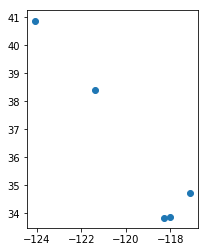

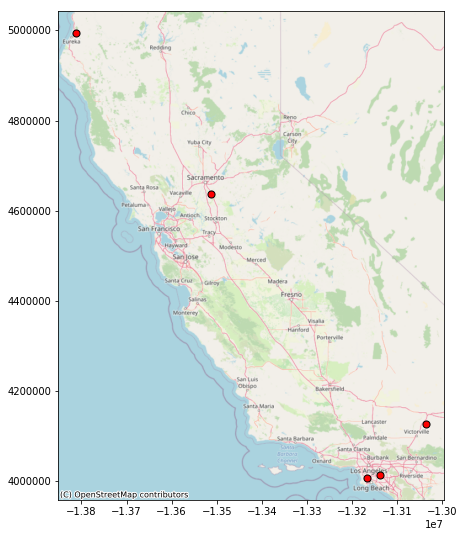

In [147]:
import geopandas as gpd
import descartes
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point,Polygon

df3=df_coll.filter(col('primary_rd').isin(r_list)).groupby('primary_rd').agg(count('chp_shift').alias('C')).sort('C',ascending=False).head(10)
lat=[33.88392,40.87949,34.7245,33.8473,38.40325]
lon=[-118.02642,-124.08336,-117.09516,-118.2724,-121.3845]
geometry=[Point(xy) for xy in zip(lon,lat)]

geo_df=gpd.GeoDataFrame(df3,crs="epsg:4326",geometry=geometry)

#df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
#ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
geo_df.plot()
#geo_df = geo_df.to_crs(epsg=3857)
#ax = geo_df.plot(figsize=(12, 12), alpha=0.5, edgecolor='k')
ax = geo_df.to_crs('EPSG:3857').plot(color="red",edgecolor="black",markersize=50,figsize=(9, 9))

#ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)

In [3]:
df_vict.select('VICTIM_SAFETY_EQUIP_1').distinct().show()

+---------------------+
|VICTIM_SAFETY_EQUIP_1|
+---------------------+
|                    K|
|                    F|
|                    Q|
|                    E|
|                    T|
|                    B|
|                    Y|
|                    M|
|                    L|
|                    V|
|                    U|
|                    D|
|                    C|
|                    J|
|                    -|
|                    A|
|                    N|
|                    X|
|                    W|
|                    S|
+---------------------+
only showing top 20 rows



In [141]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH'])

In [121]:
!pip3 install geopandas

     |████████████████████████████████| 962 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 29.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 78.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 54.8 MB/s eta 0:00:01


In [122]:
!pip3 install contextily

     |████████████████████████████████| 112 kB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 18.3 MB 8.2 MB/s eta 0:00:01


In [125]:
!pip3 install descartes